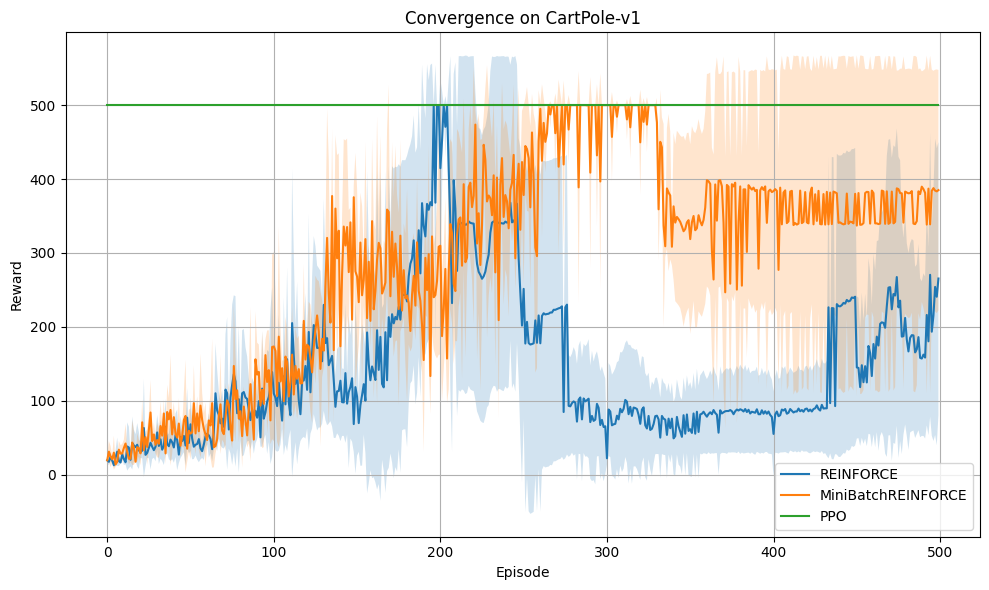

In [2]:
import numpy as np
import os
import json
import matplotlib.pyplot as plt

# Parameters
env_id = "CartPole-v1"
algorithms = ["REINFORCE", "MiniBatchREINFORCE", "PPO"]
results_dir = "results"
max_episodes = 500

# Load all seeds' rewards
data = {}

for algo in algorithms:
    algo_path = os.path.join(results_dir, algo, env_id)
    rewards = []
    for fname in os.listdir(algo_path):
        with open(os.path.join(algo_path, fname), "r") as f:
            rewards.append(json.load(f))
    data[algo] = rewards

# Plot
plt.figure(figsize=(10, 6))
for algo in algorithms:
    rewards = data[algo]
    rewards = [r[:max_episodes] for r in rewards]
    rewards = list(zip(*rewards))  # transpose: episode-major
    means = [sum(x)/len(x) for x in rewards]
    stds = [np.std(x) for x in rewards]

    episodes = list(range(len(means)))
    plt.plot(episodes, means, label=algo)
    plt.fill_between(episodes, 
                     [m - s for m, s in zip(means, stds)],
                     [m + s for m, s in zip(means, stds)],
                     alpha=0.2)

plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title(f"Convergence on {env_id}")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


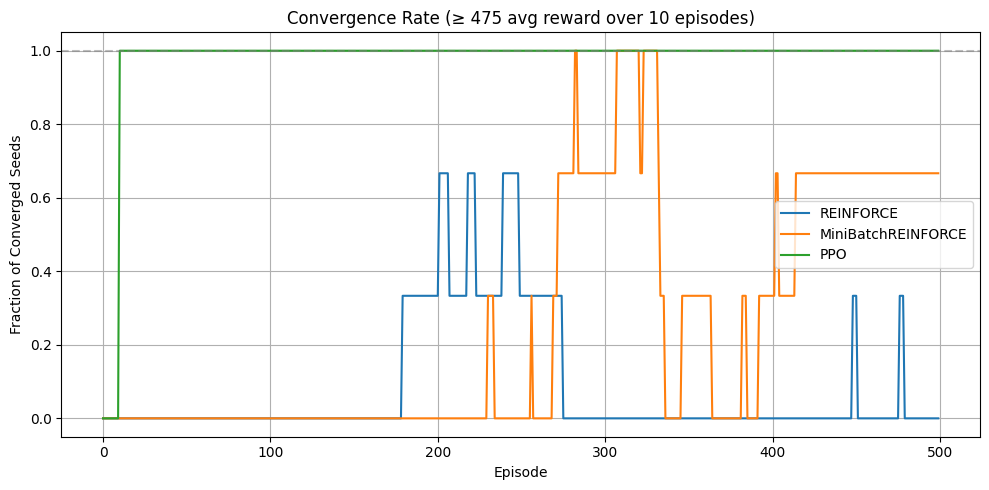

In [3]:
import numpy as np
import matplotlib.pyplot as plt

def plot_convergence_rate(data, threshold=475, window=10, max_episodes=500):
    plt.figure(figsize=(10, 5))

    for algo, runs in data.items():
        # Ensure runs are clipped to max_episodes
        runs = [r[:max_episodes] for r in runs]
        num_seeds = len(runs)
        converged_frac = []

        for ep in range(max_episodes):
            count = 0
            for r in runs:
                if ep >= window:
                    avg = np.mean(r[ep-window:ep])
                    if avg >= threshold:
                        count += 1
            converged_frac.append(count / num_seeds)
        
        plt.plot(range(max_episodes), converged_frac, label=algo)

    plt.axhline(1.0, linestyle="--", color="gray", alpha=0.5)
    plt.title(f"Convergence Rate (≥ {threshold} avg reward over {window} episodes)")
    plt.xlabel("Episode")
    plt.ylabel("Fraction of Converged Seeds")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


plot_convergence_rate(data, threshold=475)


In [4]:
def compute_avg_convergence_episode(data, threshold=475, window=10, max_episodes=500):
    print("Average convergence episode per algorithm:")
    for algo, runs in data.items():
        conv_episodes = []
        for r in runs:
            r = r[:max_episodes]
            for ep in range(window, len(r)):
                if np.mean(r[ep - window:ep]) >= threshold:
                    conv_episodes.append(ep)
                    break
        if conv_episodes:
            avg_ep = np.mean(conv_episodes)
            print(f"  {algo}: {avg_ep:.1f} (based on {len(conv_episodes)}/{len(runs)} seeds)")
        else:
            print(f"  {algo}: Did not converge in any run.")

compute_avg_convergence_episode(data)


Average convergence episode per algorithm:
  REINFORCE: 199.3 (based on 3/3 seeds)
  MiniBatchREINFORCE: 256.3 (based on 3/3 seeds)
  PPO: 10.0 (based on 3/3 seeds)


In [5]:
def convergence_probability_at_budget(data, threshold=475, window=10, budgets=[100, 200, 300, 400, 500]):
    print("Probability of convergence at fixed episode budgets:")
    for algo, runs in data.items():
        print(f"\n{algo}:")
        for B in budgets:
            count = 0
            for r in runs:
                for ep in range(window, min(len(r), B)):
                    if np.mean(r[ep - window:ep]) >= threshold:
                        count += 1
                        break
            frac = count / len(runs)
            print(f"  Up to episode {B}: {frac*100:.1f}% converged")

convergence_probability_at_budget(data)


Probability of convergence at fixed episode budgets:

REINFORCE:
  Up to episode 100: 0.0% converged
  Up to episode 200: 33.3% converged
  Up to episode 300: 100.0% converged
  Up to episode 400: 100.0% converged
  Up to episode 500: 100.0% converged

MiniBatchREINFORCE:
  Up to episode 100: 0.0% converged
  Up to episode 200: 0.0% converged
  Up to episode 300: 100.0% converged
  Up to episode 400: 100.0% converged
  Up to episode 500: 100.0% converged

PPO:
  Up to episode 100: 100.0% converged
  Up to episode 200: 100.0% converged
  Up to episode 300: 100.0% converged
  Up to episode 400: 100.0% converged
  Up to episode 500: 100.0% converged
